# **ReAct (Reasoning and Action)**

ReAct (Reasoning + Acting) is a paradigm for integrating reasoning and acting within large language models (LLMs) to enhance decision-making, task-solving efficiency, and external tool interaction. By interleaving reasoning traces with actions, ReAct allows models to:

- Maintain a coherent thought process throughout multi-step tasks.
- Reduce hallucination by verifying facts through external knowledge retrieval.
- Improve interpretability by making reasoning steps explicit.
- Adapt dynamically to new information by integrating real-time data from APIs.
- Enable complex decision-making in uncertain environments by iteratively refining outputs.

### Key Characteristics of ReAct:
1. **Reasoning**: The model generates intermediate thoughts to break down problems into logical steps.
2. **Acting**: The model interacts with tools, APIs, or external knowledge bases to gather and process relevant data.
3. **Interleaved Execution**: Reasoning and acting steps alternate, ensuring the model adjusts based on observations before taking further actions.
4. **Enhanced Transparency**: Users can inspect both reasoning traces and action logs to understand decision-making processes.
5. **Versatile Application**: Used in finance, healthcare, research, and various AI-driven workflows to improve factual accuracy and response reliability.

This synergy of reasoning and acting makes ReAct a powerful approach for interactive AI systems, surpassing traditional chain-of-thought reasoning or standalone API interactions.

paper link: https://arxiv.org/pdf/2210.03629


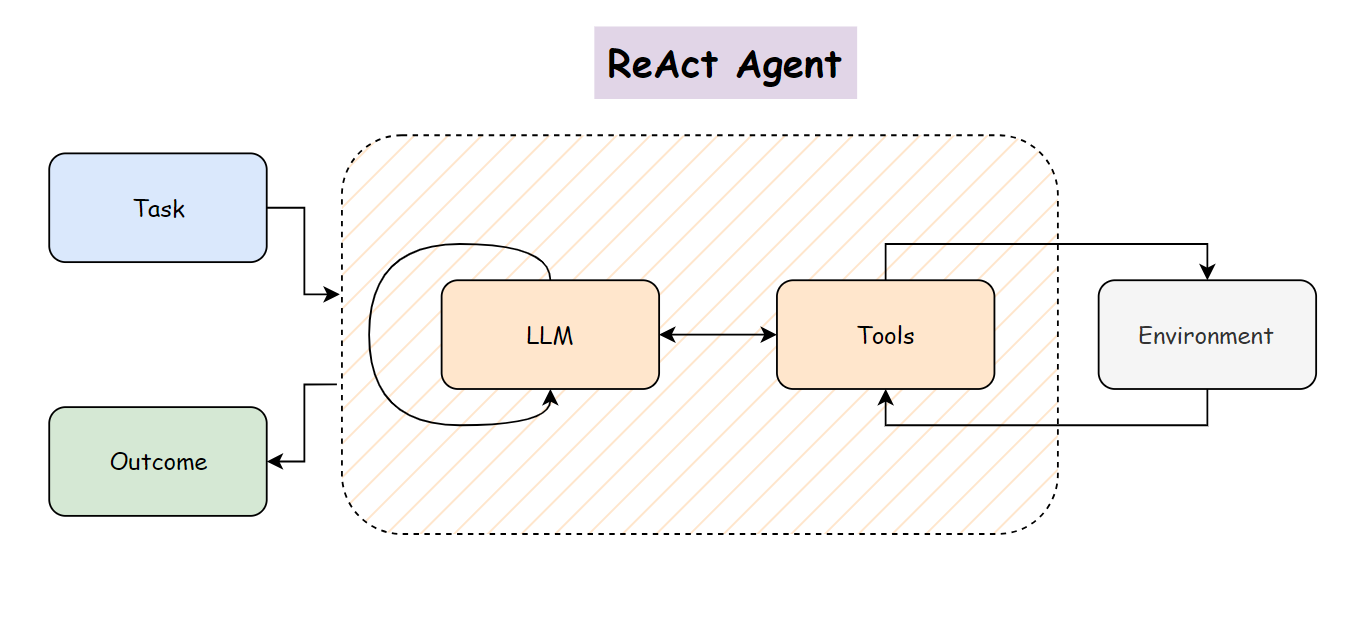

In [ ]:
# Install dependencies
!pip install  --q yfinance langgraph langchain-community langchain_openai crewai

In [ ]:
# Get the API keys
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [ ]:
# Import web search
from langchain_community.tools.tavily_search import TavilySearchResults
search = TavilySearchResults(k=3)

In [ ]:
# Define the LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [ ]:
# Define the tools
from langchain_core.tools import tool
import yfinance as yf
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from datetime import datetime

@tool
def get_current_date(tool_input=None) -> str:
    """Returns the current date in YYYY-MM-DD format.

    The LLM can use this to understand time-based queries such as
    'past 1 month' or 'last 3 weeks' in relation to today's date.
    """
    return datetime.now().strftime("%Y-%m-%d")

@tool
def web_search(query: str) -> str:
    """Tool for performing web search."""
    return search.invoke(query)

@tool
def get_stock_price(ticker: str) -> float:
    """Fetches the latest closing price of a given stock ticker.

    Args:
        ticker: The stock ticker symbol (e.g., 'AAPL').
    """
    ticker_data = yf.Ticker(ticker)
    history = ticker_data.history(period="1y")
    return history['Close']

@tool
def yahoo_finance_news(query: str) -> str:
    """Fetches news articles related to a query from Yahoo Finance.

    Args:
        ticker: The stock ticker symbol (e.g., 'AAPL').
    """
    news_tool = YahooFinanceNewsTool()
    return news_tool.invoke(query)

In [ ]:
# List of tools
tools = [get_stock_price, web_search, yahoo_finance_news, get_current_date]

## **LangChain ReAct Agent**

In [ ]:
# Get the prompt
from langchain import hub
prompt = hub.pull("hwchase17/react")

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
# Construct the ReAct agent
from langchain.agents import create_react_agent
agent = create_react_agent(llm, tools, prompt)

In [ ]:
# Create an agent executor
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)

In [ ]:
agent_executor.invoke({"input": "stocks analysis for Elon musk company for last month and latest news about company?"})



> Entering new AgentExecutor chain...
First, I need to determine which company to focus on as Elon Musk is associated with several companies. Tesla, Inc. (ticker: TSLA) is his most famous venture. I will proceed with Tesla for the stock analysis over the last month and find the latest news about the company.

Action: get_current_date
Action Input: None2025-02-13Now I know the current date is 2025-02-13. To get the stock analysis for the last month, I need to calculate the date one month prior, which would be around 2025-01-13. Next, I'll perform a search for stock price data of Tesla (TSLA) from that date till now.

Action: web_search
Action Input: "Tesla stock price from 2025-01-13 to 2025-02-13"[{'url': 'https://www.macroaxis.com/tesla-inc-stock-price', 'content': "Tesla is trading at 328.50 as of the 11th of February 2025, a 6.34 percent decrease since the beginning of the trading day. The stock's open price was"}, {'url': 'https://www.macroaxis.com/invest/history/TSLA--Tesla-Inc-

ERROR:yfinance:404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TESLA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TESLA&crumb=F4f%2FNc48yUP


No news found for company that searched with Tesla ticker.Unfortunately, I couldn't retrieve any news articles specifically from Yahoo Finance for Tesla. However, I can still provide a concise summary of Tesla's stock performance over the past month and will perform a general web search to find the latest news about Tesla.

Action: web_search
Action Input: "latest news about Tesla"[{'url': 'https://www.teslarati.com/latest-tesla-news/', 'content': 'Latest Tesla News Latest Tesla News 1.3K News Tesla reveals new features on Model Y ‘Juniper’ ----------------------------------------------- Tesla has revealed some new features on the new Model Y “Juniper” through an interview conducted at one of the company’s Northern... 236 News Ford F-150 Lightning feels the pressure from Tesla Cybertruck ------------------------------------------------------------- Ford’s electric vehicle program saw notable progress in January 2025, with the company’s overall EV sales seeing a 21.2% year-over-year ris

{'input': 'stocks analysis for Elon musk company for last month and latest news about company?',
 'output': "Over the past month, Tesla's stock price has decreased from $394.74 to $328.50. This decline might be influenced by several factors, including the company's recent recalls. The news highlights include the introduction of new features on the Model Y 'Juniper', qualification of the Cybertruck for an EV tax credit, and significant vehicle recalls that could impact customer trust and safety."}

## **CrewAI ReAct Agent**

In [ ]:
# Define the Agent
from crewai import Agent

stock_insight_agent = Agent(
    role="ReAct Agent",
    goal="Analyze stock market trends, news, and company performance to help users make informed investment decisions.",
    backstory="A financial expert with years of experience in stock market analysis, trends forecasting, and company performance evaluation.",
    tools=tools,
    verbose=True,
    llm=llm,
    )

In [ ]:
# Define the Task
from crewai import Task
stock_analysis_task = Task(
    description=(
        "Use tools to gather insights about: '{query}'. "
        "Determine the best approach dynamically based on the user's query and use the appropriate tools. "
        "If the query involves a time/period ('now', 'current', 'today', 'recent', or refers to a specific timeframe), use `get_current_date()` to determine today's date before using other tools."
        ),
    expected_output="A structured summary of the stock analysis and insights.",
    agent=stock_insight_agent
    )

In [ ]:
# Create the Crew
from crewai import Crew, Process
crew = Crew(
    agents=[stock_insight_agent],
    tasks=[stock_analysis_task],
    process=Process.sequential,
    verbose=True,
    manager_llm=llm
    )

In [ ]:
# Kickoff the Crew
result = crew.kickoff(inputs={"query": "is it worth buying apple stock for now?"})

# Agent: ReAct Agent
## Task: Use tools to gather insights about: 'is it worth buying apple stock for now?'. Determine the best approach dynamically based on the user's query and use the appropriate tools. If the query involves a time/period ('now', 'current', 'today', 'recent', or refers to a specific timeframe), use `get_current_date()` to determine today's date before using other tools.


# Agent: ReAct Agent
## Thought: To analyze whether it's worth buying Apple stock currently, I need the latest stock price and recent news that might affect its performance.
## Using tool: get_current_date
## Tool Input: 
"{}"
## Tool Output: 
2025-02-13


# Agent: ReAct Agent
## Thought: Thought: Now that I have the current date, I need to check the latest closing price of Apple stock (AAPL) and search for any recent news that might impact its valuation.
## Using tool: get_stock_price
## Tool Input: 
"{\"ticker\": \"AAPL\"}"
## Tool Output: 
Date
2024-02-13 00:00:00-05:00    184.170364
2024-02-14 

In [ ]:
print(result)

The latest closing price of Apple Inc. (AAPL) stock is $236.87. Recently, Apple announced a partnership with Alibaba to bring AI technology to iPhones in China, which is a substantial developmental stride, suggesting potential future growth. Considering the current stock price and strategic company moves, Apple's stock shows promising prospects. Thus, buying Apple stock could be considered a worthwhile investment at this moment, contingent on individual financial circumstances and investment goals.


In [ ]:
# Kickoff the Crew
result = crew.kickoff(inputs={"query": "stocks price analysis for Elon musk company for last month and latest news about company?"})

# Agent: ReAct Agent
## Task: Use tools to gather insights about: 'stocks price analysis for Elon musk company for last month and latest news about company?'. Determine the best approach dynamically based on the user's query and use the appropriate tools. If the query involves a time/period ('now', 'current', 'today', 'recent', or refers to a specific timeframe), use `get_current_date()` to determine today's date before using other tools.


# Agent: ReAct Agent
## Thought: Elon Musk is primarily associated with Tesla (TSLA) among publicly traded companies. Firstly, I need to verify the current date to calculate the required time frame for the stock price analysis.
## Using tool: get_current_date
## Tool Input: 
"{}"
## Tool Output: 
2025-02-13


# Agent: ReAct Agent
## Using tool: yahoo_finance_news
## Tool Input: 
"{\"query\": \"TSLA\"}"
## Tool Output: 
Tesla, Inc. (TSLA): “Proactive in AI & AV Tech,” Says Morgan Stanley
We recently published a list of Top 12 AI Stocks Dominating the

In [ ]:
print(result)

Over the last month, Tesla's stock price has shown significant fluctuations. The price started at $374.32 on February 6th, 2025, dropped to a low of $328.5 on February 11th, and slightly recovered to $336.51 by February 12th, 2025.

The recent news highlights Tesla's proactive stance in AI and autonomous vehicle technology, with analysts from Morgan Stanley acknowledging its efforts. The reports suggest a strong competitive position in the AI market, although the stock market's reaction shows some volatility, possibly reflecting broader market trends or company-specific events.
